<a href="https://colab.research.google.com/github/TQT2203/btvn/blob/main/BTVN_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
pip install tensorflow opencv-python matplotlib scikit-learn


In [1]:
import zipfile
import os

# Đường dẫn tới file ZIP
zip_path = "dataset.zip"
extract_to = "dataset"

# Giải nén
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Đã giải nén tập ảnh huấn luyện.")


✅ Đã giải nén tập ảnh huấn luyện.


In [62]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# === Cấu hình ===
IMG_SIZE = 100
EPOCHS = 10
dataset_path = "dataset"

# === Load & tiền xử lý dữ liệu ===
data = []
labels = []
label_map = {}
label_id = 0

for folder in os.listdir(dataset_path):
    if "_" not in folder:
        continue
    label_name = folder.lower()
    folder_path = os.path.join(dataset_path, folder)

    if not os.path.isdir(folder_path):
        continue

    label_map[label_id] = label_name

    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        face = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
        data.append(face)
        labels.append(label_id)

    label_id += 1

# Chuyển dữ liệu thành mảng NumPy
X = np.array(data).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
y = to_categorical(labels)

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Tập huấn luyện: {X_train.shape[0]} mẫu, Tập kiểm tra: {X_test.shape[0]} mẫu")

# === Tạo mô hình CNN ===
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(label_map), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === Huấn luyện ===
model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test))

# === Lưu mô hình (tùy chọn) ===
model.save("cnn_face_emotion_model.h5")
print("✅ Mô hình đã được huấn luyện và lưu.")


✅ Tập huấn luyện: 28 mẫu, Tập kiểm tra: 8 mẫu
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0714 - loss: 2.5812 - val_accuracy: 0.0000e+00 - val_loss: 3.4067
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step - accuracy: 0.1429 - loss: 2.5286 - val_accuracy: 0.0000e+00 - val_loss: 3.1459
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step - accuracy: 0.1429 - loss: 2.4890 - val_accuracy: 0.0000e+00 - val_loss: 2.7277
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step - accuracy: 0.1429 - loss: 2.2619 - val_accuracy: 0.0000e+00 - val_loss: 2.6450
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step - accuracy: 0.1786 - loss: 2.2860 - val_accuracy: 0.0000e+00 - val_loss: 2.6503
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3214 - loss: 2.1775 - val_accuracy: 0.0000e+00 - val_loss: 2.7542
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step - accuracy: 0.6786 - loss: 1.9118 - val_accuracy: 0.0000e+00 - val_loss: 2.9422
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step 

✅ Mô hình đã được huấn luyện và lưu.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
👉 Đây là THÁI và đang cảm thấy NORMAL (0.15)


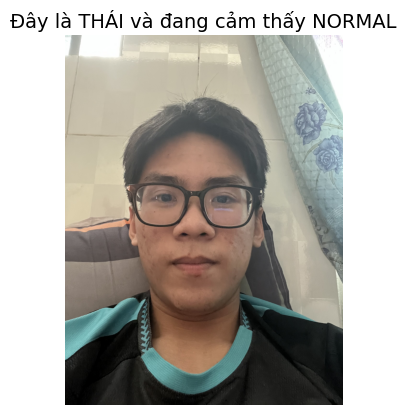

In [65]:
def predict_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("❌ Không thể đọc ảnh.")
        return

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
    face_input = face.reshape(1, IMG_SIZE, IMG_SIZE, 1) / 255.0

    pred = model.predict(face_input)[0]
    label_id = np.argmax(pred)
    confidence = pred[label_id]
    label_name = label_map[label_id]
    person, emotion = label_name.split("_", 1)

    print(f"👉 Đây là {person.upper()} và đang cảm thấy {emotion.upper()} ({confidence:.2f})")

    # Hiển thị ảnh kèm chú thích
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f"Đây là {person.upper()} và đang cảm thấy {emotion.upper()}", fontsize=14)
    plt.axis("off")
    plt.show()
predict_image("/content/IMG_1627.jpg")